In [9]:
import urllib.request
import imageio
import tarfile
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
#import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Lambda
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
#from tf_keras_vis.gradcam import Gradcam
#from tf_keras_vis.saliency import Saliency
#from tf_keras_vis.utils import normalize

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_dir = 'data/train/'
val_dir = 'data/val/'
target_size = (150, 150)
batch_size = 64
class_mode='binary'


train_ds =  train_datagen.flow_from_directory(
    train_dir,
    target_size = target_size,
    batch_size = batch_size,
    shuffle = True,
    class_mode=class_mode
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size = target_size,
    shuffle = True,
    batch_size = batch_size,
    class_mode=class_mode
)


Found 374 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [12]:
img_width = 150
img_height = 150
## CNN model - Baseline
tf.keras.backend.clear_session()
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
#cnn_model.add(Conv2D(512, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
#cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
#cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(activation = 'relu', units = 128))
cnn_model.add(Dense(activation = 'sigmoid', units = 1))
print(cnn_model.summary())
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                        

In [13]:
##  CNN model compilation and Training
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 5, verbose=1)
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-3, mode='min', restore_best_weights=True)
#callbacks_list = [es, learning_rate_reduction]


In [14]:
history_cnn = cnn_model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=125,
                      verbose=1)

Epoch 1/125
6/6 [==============================] - 4s 516ms/step - loss: 0.8536 - accuracy: 0.5027 - val_loss: 0.6917 - val_accuracy: 0.5376
Epoch 2/125
6/6 [==============================] - 3s 523ms/step - loss: 0.7576 - accuracy: 0.5588 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/125
6/6 [==============================] - 3s 543ms/step - loss: 0.6899 - accuracy: 0.6176 - val_loss: 0.6924 - val_accuracy: 0.5753
Epoch 4/125
6/6 [==============================] - 4s 579ms/step - loss: 0.6727 - accuracy: 0.6123 - val_loss: 0.6927 - val_accuracy: 0.5054
Epoch 5/125
6/6 [==============================] - 4s 608ms/step - loss: 0.6405 - accuracy: 0.6444 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 6/125
6/6 [==============================] - 4s 591ms/step - loss: 0.6855 - accuracy: 0.6471 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 7/125
6/6 [==============================] - 3s 558ms/step - loss: 0.5899 - accuracy: 0.6952 - val_loss: 0.6995 - val_accuracy: 0.5000
Epoch 8/125
6

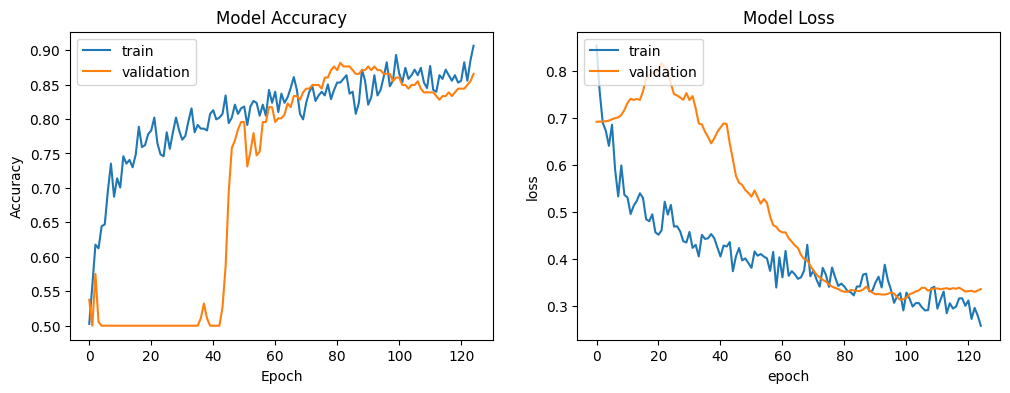

In [15]:
## plot CNN model history for accuracy and loss
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    ## summarize history for accuracy
    ax[0].plot(history_cnn.history['accuracy'])
    ax[0].plot(history_cnn.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history_cnn.history['loss'])
    ax[1].plot(history_cnn.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')

    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_cnn);